A. Objective:
    1. Predict how long a flight is to be delayed [target: ArrivalDelayGroups or/and ArrDelay]
    2. Build front-end interface for the models
B. Data
    1. [x] Write an API to download data straigth from transtats
    2. [x] Write an API to source airports data: location and ranking
    3. [x] Build database of flights, airports and airlines
C. Data Cleaning and Munging
    1. Combine tables
    2. Treat missing values
    3. Create new features: 
        - DaystoHoliday: how many days is a day to the closest holiday
        - RecTime: time recovered on departure and arrival delay time
        - Normalize delay times with respect to Airtime

D. Hypothesis
   
   Flights delays may be influenced by
    - date (year, month, day of the month, day of the week, week of the year)
    - local time 
    - origin airport
    - destination airport
    - airline
    - Furthermore, historical data on flight delays may be informative about future delays. For instance, weather related reasons of delays last year may occur again this year within the same period of the year

E. Exploratory data analysis
   Here, we shall explore available data to validate our hypothesis. 
 
F. Modeling

In [174]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import json, zipfile, StringIO, requests, ggplot

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# initialize a connection to the database
import sqlite3
conn = sqlite3.connect('data/database.db')

# initialize another sqlalchemy connection to the same database to be able to query data straight to pandas dataframe
from sqlalchemy import create_engine
disk_engine = create_engine('sqlite:///data/database.db')

import imp
fl_module = imp.load_source('fl_module', 'scripts/flights_module.py')

from sklearn.preprocessing import Imputer, LabelEncoder, MultiLabelBinarizer

## Functions

In [74]:
def collectData(y_range,m_range,transtat_obj,conn):
    """collect data from transtats and insert them in the database"""
    transt = transtat_obj
    for year in y_range:
        for month in m_range:
            tic = dt.datetime.now()
            df = transt.get_flightsData(year,month)
            df['WeekofYear'] = df.apply(lambda r:getWeekofYear(r['Year'],r['Month'],r['DayofMonth']),axis=1)
            df.to_sql('flights_data',conn,index=False,if_exists='append')
            print year,month,dt.datetime.now()-tic
    print "Done collecting data"

def getWeekofYear(year,month,day):
    return dt.date(year,month,day).isocalendar()[1]


def clean_date(year,date):
    """Used to clean holidays date format"""
    day2Int = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    month2Int = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
                 'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
    r = re.sub('[\W_]','|',date).split('|')
    month = month2Int[r[2]]
    dayofWeek = day2Int[r[0]]
    dayofMonth = int(r[3])
    return dt.datetime(year,month,dayofMonth)

def daystocloseholiday(date,hdays=holidays):
    """calculate the days between a given date and the closest holiday to it"""
    hdays = (hdays.Date-date).min()
    
    return hdays

## Data
 

In [3]:
print "Tables in the db:", map(lambda x:str(x[0]),conn.execute("select name from sqlite_master where type='table'").fetchall())

Tables in the db: ['lookup_Airport', 'lookup_CancellationCode', 'lookup_Carrier', 'lookup_DelayGroup', 'lookup_TimeBlock', 'lookup_DistanceGroup', 'flights_data', 'Airport_Coordinates', 'Airport_Rank']


In [4]:
transtats = fl_module.Transtats()
faa = fl_module.Faa()

In [5]:
## collect data and insert to database
## Note: The the following line is time consuming so comment them out where it is really necessary
# collectData([2016],range(1,13),transtats,conn) #<- uncomment to collect data

## set the create_index to True if you need to create index on the table in the database. It is time consuming
create_index = False 
if create_index:
    conn.execute("CREATE INDEX fl_index ON flights_data(Year, Month, Carrier, Origin, OriginCityName, OriginState, "
                 "Dest, DestCityName, DestState, DepartureDelayGroups, ArrivalDelayGroups, "
                 "DepTimeBlk, ArrTimeBlk, WeekofYear)")

In this notebook, we use on-time flight data since 2010. Our analysis will only focus on:
- large hubs: As defined by FAA, these are airports that host at least 1% of all travelling passengers in US. These were implemented in the FAA api
- major airlines: I will define these are airlines that were operational since 2010 until today

In [6]:
# get a list of large hubs from faa
large_hubs = faa.large_hubs

# get airlines and there performance from the database
## let's first get a list of all features from the flights_data table
features = pd.read_sql_query("select * from flights_data limit 1", disk_engine).columns.tolist()
print features

[u'Year', u'Quarter', u'Month', u'DayofMonth', u'DayOfWeek', u'FlightDate', u'UniqueCarrier', u'AirlineID', u'Carrier', u'TailNum', u'FlightNum', u'OriginCityMarketID', u'Origin', u'OriginCityName', u'OriginState', u'DestCityMarketID', u'Dest', u'DestCityName', u'DestState', u'CRSDepTime', u'DepTime', u'DepDelay', u'DepDelayMinutes', u'DepDel15', u'DepartureDelayGroups', u'DepTimeBlk', u'TaxiOut', u'TaxiIn', u'CRSArrTime', u'ArrTime', u'ArrDelay', u'ArrDelayMinutes', u'ArrDel15', u'ArrivalDelayGroups', u'ArrTimeBlk', u'Cancelled', u'CancellationCode', u'Diverted', u'CRSElapsedTime', u'ActualElapsedTime', u'AirTime', u'Flights', u'Distance', u'DistanceGroup', u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay', u'LateAircraftDelay', u'WeekofYear']


In [7]:
## now construct a table of airlines with the number of total flights per year
tic = dt.datetime.now()
airline_performance = pd.read_sql_query("SELECT Year, Carrier, COUNT(CARRIER) AS Flights "
                                        "FROM flights_data "
                                        "GROUP BY Year, Carrier "
                                        "ORDER BY Year",
                                        disk_engine)
airline_performance = pd.pivot(index=airline_performance.Year.values, 
                               columns=airline_performance.Carrier.values, 
                               values=airline_performance.Flights)
airline_performance
print dt.datetime.now()-tic

0:01:32.596501


A quick look at the table shows that some airliens stopped operating for some years. We will only focus on those without missing values in the table and call them major airlines

In [9]:
# define list of major airlines
major_airlines = map(lambda x:str(x),airline_performance.T.dropna().T.columns.tolist())
major_airlines

['AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'OO', 'UA', 'WN']

We shall first play with a sample over one year to define all pipeline we need to apply on our dataset.
As we have major airlines and large hubs in hand, we can now send a sql query to get 2010 flights data for only major airlines at large hubs

In [10]:
tic = dt.datetime.now()
sample = pd.read_sql_query("SELECT * FROM flights_data "
                           "WHERE Year = 2010 AND Carrier IN {0} "
                           "AND ORIGIN IN {1} AND DEST IN {1}".format(tuple(major_airlines),tuple(large_hubs)),
                          disk_engine)
print dt.datetime.now()-tic

0:01:14.627437


In [278]:
# import holidays dataset
holidays = pd.read_csv('data/holidays.csv')
holidays.Date = pd.to_datetime(holidays.Date,infer_datetime_format=True)
holidays['Month'] = holidays.Date.apply(lambda x:x.month)
holidays['Week'] = map(lambda x:x.isocalendar()[1],holidays.Date)
#print "before cleaning:"
#print holidays.head()

#holidays['Date'] = holidays.apply(lambda r:clean_date(r[0],r[1]),axis=1)
#print "after cleaning:"
print holidays.head()

   Year       Date                              Holiday  Month  Week
0  2010 2010-01-01                       New Year's Day      1    53
1  2010 2010-01-18  Birthday of Martin Luther King, Jr.      1     3
2  2010 2010-02-15                Washington's Birthday      2     7
3  2010 2010-05-31                         Memorial Day      5    22
4  2010 2010-07-05                     Independence Day      7    27


## Data Cleaning and Munging
    1. Treat missing values
    2. Combine tables
    3. Create new features: 
        - WeekofYear: week of the year
        - DaystoHoliday: how many days is a day to the closest holiday
        - RecTime: time recovered on departure and arrival delay time
        - Normalize delay times with respect to Airtime

### Missing values

In [11]:
float_features = [ u'DepDelay', u'DepDelayMinutes', u'TaxiOut', u'TaxiIn', u'ArrDelay', u'ArrDelayMinutes', 
                  u'CRSElapsedTime', u'ActualElapsedTime', u'AirTime', u'Distance', u'CarrierDelay', 
                  u'WeatherDelay', u'NASDelay', u'SecurityDelay', u'LateAircraftDelay']
int_features = [u'Year', u'Quarter', u'Month', u'DayofMonth', u'DayOfWeek', u'WeekofYear', u'AirlineID', u'FlightNum', 
                u'OriginCityMarketID', u'DestCityMarketID', u'DepTime', u'CRSDepTime', u'DepDel15', u'ArrTime', 
                u'CRSArrTime', u'ArrDel15', u'DepartureDelayGroups', u'ArrivalDelayGroups', u'Cancelled', u'Diverted', 
                u'DistanceGroup', u'Flights', ]
str_features = [ u'UniqueCarrier', u'Carrier', u'TailNum', u'Origin', u'OriginCityName', 
                u'OriginState', u'Dest', u'DestCityName', u'DestState', u'DepTimeBlk', u'ArrTimeBlk', 
                u'CancellationCode']
date_features = [u'FlightDate']


Loop through each feature, replace missing value with most frequent value of that feature and convert the feature in the right data type

In [196]:

tic = dt.datetime.now()
feature_with_NA = []
data =  pd.DataFrame()
print "date data types ..."
for feature in date_features:
    if sample[sample[feature].isnull()].shape[0]>0:
        feature_with_NA.append((feature,sample[sample[feature].isnull()].shape[0]))
        most_freq = sample[feature].mode().values[0]
        sample[feature] = sample[feature].fillna(most_freq)
    data[feature] = pd.to_datetime(sample[feature]).astype(pd.tslib.Timestamp)
    
print "int data types ..."
for feature in int_features:
    if sample[sample[feature].isnull()].shape[0]>0:
        feature_with_NA.append((feature,sample[sample[feature].isnull()].shape[0]))
        most_freq = sample[feature].mode().values[0]
        sample[feature] = sample[feature].fillna(most_freq)
    data[feature] = sample[feature].astype(int)

print "float data types ..."
for feature in float_features:
    if sample[sample[feature].isnull()].shape[0]>0:
        feature_with_NA.append((feature,sample[sample[feature].isnull()].shape[0]))
        most_freq = sample[feature].mode().values[0]
        sample[feature] = sample[feature].fillna(most_freq)
    data[feature] = sample[feature].astype(float)

print "str data types ..."
for feature in str_features:
    if sample[sample[feature].isnull()].shape[0]>0:
        feature_with_NA.append((feature,sample[sample[feature].isnull()].shape[0]))
        most_freq = sample[feature].mode().values[0]
        sample[feature] = sample[feature].fillna(most_freq)
    data[feature] = sample[feature].astype(str)

print dt.datetime.now()-tic

date data types ...
int data types ...
float data types ...
str data types ...
0:00:34.069284


In [197]:
# sort data frame by flight date
data = data.sort_values('FlightDate').reset_index()
data = data.drop('index',axis=1)

### Feature engineering

In [198]:
# drop features
to_drop = [u'AirlineID',u'FlightNum',u'UniqueCarrier', u'TailNum',u'OriginCityName',u'DestCityName',
           u'OriginCityMarketID',u'DestCityMarketID', 
           u'CRSDepTime',u'CRSArrTime',u'DepTime',u'ArrTime', #These contain same information as Dep/ArrTimeBlk
           u'DepDel15',u'ArrDel15', #Same information contained in Departure/ArrivalDelayGroups
           u'CRSElapsedTime',u'ActualElapsedTime', #these would cause data leakage
           u'Year',u'Quarter'] #These would not be removed if dealing with data from many years
data.drop(to_drop,axis=1,inplace=True)


In [199]:
## drop features with zero variance
zero_vars = []
for col in data.columns:
    if data[col].dtype.name in ['int64','float64']:
        zero_vars.append((col,data[col].var()))
## zero_vars reveals that Diverted, Cancelled and Flights should be dropped as their variance is less than 0.1
data.drop(['Diverted','Cancelled'],axis=1,inplace=True) # For now we keep Flights because it will be used a lot in counting

In [200]:

# recovered time: Time reduced on the initial departure delay
data['RecTime'] = map(lambda x,y:-x - y if ((x<0) & (y<0)) else x - y,data.DepDelay.values,data.ArrDelay.values)

# days to closest holiday <- time consuming. To be explored later
#data['DaystoCloseHoliday'] = map(lambda x:daystocloseholiday(x,holidays),data.FlightDate.values)
#print dt.datetime.now()-tic

In [201]:
# convert categorical to numerical
## Later, consider using MultipleLabelEncoder for non-ordered categorical features

tic = dt.datetime.now()
lEncoder = {}
for f in str_features:
    if f in data.columns:
        lEncoder[f] = LabelEncoder()
        data[f] = lEncoder[f].fit_transform(data[f])
print dt.datetime.now()-tic

0:00:19.023658


## EDA

We shall start with features that are available to the user at the time of booking:
- FlightDate, Month, DayofMonth, DayofWeek, WeekofYear, DepTimeBlk, ArrTimeBlk
- Origin, Dest
- Distance, DistanceGroup, AirTime
- OriginState, DestState
- Carrier

The rest could be used later as part of historical information

In [255]:
sample1 = data[['FlightDate','Month','DayofMonth','DayOfWeek','WeekofYear','DepTimeBlk','ArrTimeBlk','Carrier',
                'Origin','Dest','OriginState','DestState','Distance','DistanceGroup','AirTime','Flights',
                'DepartureDelayGroups','ArrivalDelayGroups']]
target = data['ArrivalDelayGroups']
sample1.head()

,FlightDate,Month,DayofMonth,DayOfWeek,WeekofYear,DepTimeBlk,ArrTimeBlk,Carrier,Origin,Dest,OriginState,DestState,Distance,DistanceGroup,AirTime,Flights,DepartureDelayGroups,ArrivalDelayGroups
0,2010-01-01 00:00:00,1,1,5,53,7,8,8,4,21,19,6,612.0,3,93.0,1,-1,-2
1,2010-01-01 00:00:00,1,1,5,53,12,16,9,26,24,20,0,1107.0,5,141.0,1,2,1
2,2010-01-01 00:00:00,1,1,5,53,5,9,3,20,9,10,3,1487.0,6,193.0,1,1,0
3,2010-01-01 00:00:00,1,1,5,53,12,14,3,0,2,4,8,576.0,3,74.0,1,-1,-1
4,2010-01-01 00:00:00,1,1,5,53,3,4,4,3,0,11,4,227.0,1,45.0,1,-1,-2


### Verification of hypothesis
#### Influence of date on delay

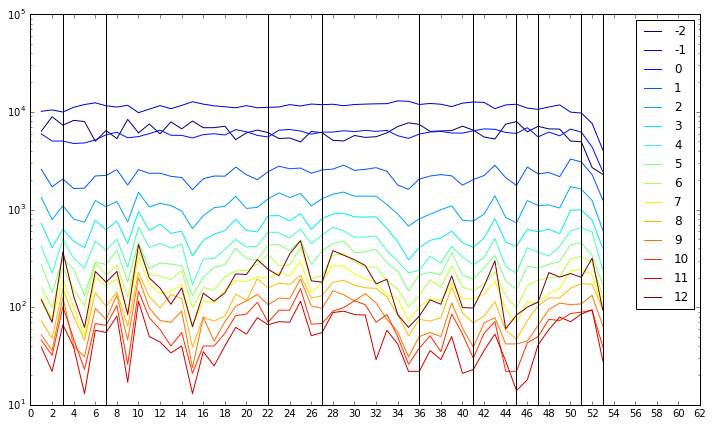

In [288]:
# plot delay groups by week of the year
# Within the first 16 weeks:
# - there seem to be periodic change in number of delays in groups 1-12.
# - group -2 to 0 seem invariant over time
arrByDate =sample1[['WeekofYear','ArrivalDelayGroups','Flights']].groupby(['WeekofYear','ArrivalDelayGroups']).sum().reset_index()

arrivalDelayGroups = sorted(pd.unique(arrByDate.ArrivalDelayGroups))
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0,1,len(arrivalDelayGroups))]
fig,ax = plt.subplots(1,1,figsize=[12,7])
for g,color in enumerate(colors,start=-2):
    df = arrByDate[arrByDate.ArrivalDelayGroups == g]
    df.index = df.WeekofYear.values
    df.Flights.plot(color=color,ax=ax)
for val in holidays[holidays.Year == 2010]['Week']:
    plt.axvline(x=val,ymin=0,ymax=100000,color='k')
plt.legend(pd.unique(arrByDate.ArrivalDelayGroups))
plt.yscale('log')
plt.xticks(range(0,64,2),range(0,64,2))
plt.show()

In [286]:
holidays[holidays.Year == 2010]

,Year,Date,Holiday,Month,Week
0,2010,2010-01-01,New Year's Day,1,53
1,2010,2010-01-18,"Birthday of Martin Luther King, Jr.",1,3
2,2010,2010-02-15,Washington's Birthday,2,7
3,2010,2010-05-31,Memorial Day,5,22
4,2010,2010-07-05,Independence Day,7,27
5,2010,2010-09-06,Labor Day,9,36
6,2010,2010-10-11,Columbus Day,10,41
7,2010,2010-11-11,Veterans Day,11,45
8,2010,2010-11-25,Thanksgiving Day,11,47
9,2010,2010-12-24,Christmas Day,12,51
